In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin

def gen_pcorr(df, method = "pearson", sig = 0.01):
    # Correlation type:
    # 'pearson': Pearson r product-moment correlation
    # 'spearman': Spearman ρ rank-order correlation
    # 'kendall': Kendall’s τB correlation (for ordinal data)
    # 'bicor': Biweight midcorrelation (robust)
    # 'percbend': Percentage bend correlation (robust)
    # 'shepherd': Shepherd’s pi correlation (robust)
    # 'skipped': Skipped correlation (robust)
    pcs_dct = {}
    sig_corr_dct = {}
    for x in df.keys():
        sig_corr_dct[x] = []
        pcs_dct[x]={}
        for y in df.keys():
            # control variables
            # select variables that are not x or y
            other_vars = [z for z in df.keys() if z != y and z != x ]
            if x == y:
                # No need to calculate if the variable is itself
                pcs_dct[x][y] = 1
            else:
                pcs_dct[x][y] = df.partial_corr(x=x,y=y, covar=other_vars,
                                      method=method).round(3)
                if pcs_dct[x][y]["p-val"].values[0] < sig:
                    sig_corr_dct[x].append((y, pcs_dct[x][y]["r"].values[0]))

    return pcs_dct, sig_corr_dct

            

    
mpl_colors = ["C" + str(i) for i in range(10)]
mpl_colors = mpl_colors + ["b", "m", "c", "y"]
#list(mpl.colors.cnames.values())
#random.shuffle(mpl_colors)
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df
    
def plot_lines(df, plot_vars, linewidth = 1, logy = False, figsize = (40,20), 
    secondary_y = None, pp = None):
    
    fig, ax = plt.subplots(figsize = figsize)
    
    legend_scale = 20 / figsize[1]
    # If no secondary_y (axis), plot all variables at once
    if secondary_y == None:
        df[plot_vars].plot.line(linewidth = linewidth, logy = logy, ax = ax, ls = "-")
        ax.legend(bbox_to_anchor=(0, 1.035 + .045 * len(plot_vars) * legend_scale), 
                  loc=2)
    # Otherwise, create a new axis and plot each variable individually
    else:
        ax2 = ax.twinx()
        for var in plot_vars:
            if var == secondary_y: 
                df[var].plot.line(linewidth = linewidth, logy = logy, ax = ax2, 
                  c = "C9",
                  label = var + " (right)")
            else:
                df[var].plot.line(linewidth = linewidth, logy = logy, ax = ax)
        # If there are two axes, then gather lines from each axis
        lines = ax.get_lines() + ax2.get_lines()
        # then gather the label from each line
        labels = [l.get_label() for l in lines]
        # and use the lines and labels to create the legend
        ax.legend(lines, labels, bbox_to_anchor=(0, 
                1.04 + .045 * len(plot_vars) * legend_scale), loc=2)
    # Turn the text on the x-axis so that it reads vertically
    ax.hlines(0, linestyle = "--", xmin = 0, xmax = df.index[-1])
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    plt.savefig(str(plot_vars).replace("[", "").replace("]","").replace(":", "").replace("$","").replace("'","")[:50] + " line.png", 
                bbox_inches = "tight")
    plt.show()
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, logy = False, figsize = (40,20), 
                       pp = None, sep_var = False):
    fig, ax = plt.subplots(figsize = figsize)
    
    legend_scale = 20 / figsize[1]
#    cmap = "Greys"
    cmap = None
    if sep_var == False:
        # If no secondary_y (axis), plot all variables at once
        df[plot_vars].plot.area(stacked = True, linewidth = linewidth, logy = logy, 
          cmap=cmap, ax = ax, color = mpl_colors)
        ax.legend(bbox_to_anchor=(0, 1.035 + .045 * math.ceil(len(plot_vars) / 2) * legend_scale), loc = 2, ncol = 2)
    else:
        # If no secondary_y (axis), plot all variables at once
        df[plot_vars].plot.area(stacked = True, linewidth = linewidth, logy = logy, 
          cmap = cmap, ax = ax, legend = False, label = plot_vars, color = mpl_colors)
        df[sep_var].plot.line(linewidth = linewidth, logy = logy, ax = ax, c = "k",
          label = sep_var, ls = "--")
        # If there are two axes, then gather lines from each axis
#        lines = ax.get_lines()
#        # then gather the label from each line
#        labels = [l.get_label() for l in lines]
        # and use the lines and labels to create the legend
#        ax.legend(lines, labels, bbox_to_anchor=(0, 
#                1.04 + .045 * len(plot_vars) * legend_scale), loc=2)
        ax.legend(bbox_to_anchor=(0, 1.035 + .045 * math.ceil((len(plot_vars) + 1) / 2) * legend_scale), 
                  loc=2, ncol = 2)

    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # save image if PdfPages object was passed
    plt.savefig(str(plot_vars).replace("[", "").replace("]","").replace(":", "").replace("$","").replace("'","")[:50] + " stack.png",
                bbox_inches = "tight")
    plt.show()
    if pp != None: pp.savefig(fig, bbox_inches = "tight")
    plt.close()
    
def plot_scatter(df, plot_vars, s = 75, figsize = (40, 20), pp = None):
    # Create plot for every unique pair of variables
    for var1 in plot_vars:
        for var2 in plot_vars:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, c = "Year",
                                cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
#                plt.savefig(str(plot_vars).replace("[", "").replace("]","") + " scatter.png",
#                            bbox_inches = "tight")
                if df[var1].min() < 0:
                    plt.axvline(0, ls = "--", c = "k")
                if df[var2].min() < 0:
                    plt.axhline(0, ls = "--", c = "k")
                plt.show()
                if pp != None: pp.savefig(fig, bbox_inches = "tight")
                plt.close()


    
# Create PDF that will hold visualizations
today = datetime.datetime.today()
# set default fontsize for text in plot
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.ymargin'] = .05
plt.rcParams['axes.xmargin'] = .05
# Choose data from FRED
# Keys will be used to name variable. Key points to FRED code
data_codes  = {"Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURRCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Excess Reserves (%)": "IOER"}

In [2]:
data_dict = {}
freq = "Q"
start = datetime.datetime(1990, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end = datetime.datetime.today()

# Select start and end dates
# end = datetime.datetime.today()
# Check if data has been gathered.
# If data needs to be gathered again, clear variables or restart kernel
if "data_gathered" not in locals():
    df = gather_data(data_codes, start, 
          end = end, freq = freq)
    ticker = "^GSPC"
    freq = "Q"
    df.fillna(0, inplace=True)
    df["Private Investment Growth Rate (%)"] = df["Private Investment"].pct_change(4)
    # Create new variables
    df["Base: Currency in Circulation ($ Mil)"] = df["Base: Currency in Circulation ($ Bil)"].mul(1000)
    df["Base: Currency not in Circulation ($ Mil)"] = df["Base: Total ($ Mil)"].sub(df["Base: Currency in Circulation ($ Mil)"])
    df["Currency in Circulation Growth Rate (%)"] = df["Base: Currency in Circulation ($ Mil)"].pct_change(4) * 100
    df["% Currency not in Circulation"] = df["Base: Currency not in Circulation ($ Mil)"].div(df["Base: Total ($ Mil)"]) * 100
    df["% Currency in Circulation"] = df["Base: Currency in Circulation ($ Mil)"].div(df["Base: Total ($ Mil)"]) * 100
    df["Base: Total Growth Rate (%)"] = df["Base: Total ($ Mil)"]
    df["Change % Currency not in Circulation"] = df["% Currency not in Circulation"].diff(4)    
    df["Currency not in Circulation Growth Rate (%)"] = df["Base: Currency not in Circulation ($ Mil)"].pct_change(4) * 100    
    df["Inflation (CPI)"] = df["CPI"].pct_change(4) * 100
    df["Effective Federal Funds Rate (%; Change Year-over-Year)"] = df["Effective Federal Funds Rate (%)"].diff(4)
    df["1 Year Treasury Rate (%; Change Year-over-Year)"] = df["1 Year Treasury Rate (%)"].diff(4)
    df["2 Year Treasury Rate (%; Change Year-over-Year)"] = df["2 Year Treasury Rate (%)"].diff(4)
    df["10 Year Treasury Rate (%; Change Year-over-Year)"] = df["10 Year Treasury Rate (%)"].diff(4)
    df["30 Year Treasury Rate (%; Change Year-over-Year)"] = df["30 Year Treasury Rate (%)"].diff(4)
    
    df["Nominal GDP ($ Mil)"] = df["Nominal GDP ($ Bil)"].mul(1000)
    df["Nominal GDP Growth Rate (%)"] = df["Nominal GDP ($ Bil)"].pct_change(4) * 100
    df["Real GDP ($ Mil)"] = df["Real GDP ($ Bil)"].mul(1000)
    df["Real GDP Growth Rate (%)"] = df["Real GDP ($ Bil)"].pct_change(4) * 100
    df["Inflation (GDPDEF)"] = df["GDP Deflator"].pct_change(4) * 100
    df["Real Currency in Circulation Growth Rate (%)"] = df["Currency in Circulation Growth Rate (%)"].sub(df["Inflation (GDPDEF)"])
    df["Currency in Circulation Velocity"] = df["Nominal GDP ($ Mil)"].div(df["Base: Currency in Circulation ($ Mil)"])
    df["Currency in Circulation % Change Velocity"] = df["Currency in Circulation Velocity"].pct_change(4)
    
    

    
    df["Real 1 Year Treasury Rate"] = df["1 Year Treasury Rate (%)"].sub(df["Inflation (CPI)"])
    df["Real 3 Month Treasury Rate"] = df["3 Month Treasury Rate (%)"].sub(df["Inflation (CPI)"])
    df["Real 1 Month Treasury Rate"] = df["1 Month Treasury Rate (%)"].sub(df["Inflation (CPI)"])
    df["Real Effective Federal Funds Rate"] = df['Effective Federal Funds Rate (%)'].sub(df["Inflation (CPI)"])
    
    df["30 Year Minus 1 Year (%)"] = df["30 Year Treasury Rate (%)"].sub(df["1 Year Treasury Rate (%)"])
    df["30 Year Minus 3 Month (%)"] = df["30 Year Treasury Rate (%)"].sub(df["3 Month Treasury Rate (%)"])
    df["30 Year Minus 1 Month (%)"] = df["30 Year Treasury Rate (%)"].sub(df["1 Month Treasury Rate (%)"])
    df["30 Year Minus Effective Federal Funds Rate"] = df["30 Year Treasury Rate (%)"].sub(df['Effective Federal Funds Rate (%)'])
    df["10 Year Minus 2 Year (%)"] = df["10 Year Treasury Rate (%)"].sub(df["2 Year Treasury Rate (%)"])
    df["10 Year Minus 1 Year (%)"] = df["10 Year Treasury Rate (%)"].sub(df["1 Year Treasury Rate (%)"])
    df["10 Year Minus 3 Month (%)"] = df["10 Year Treasury Rate (%)"].sub(df["3 Month Treasury Rate (%)"])
    df["10 Year Minus 1 Month (%)"] = df["10 Year Treasury Rate (%)"].sub(df["1 Month Treasury Rate (%)"])
    df["10 Year Minus Effective Federal Funds Rate"] = df["10 Year Treasury Rate (%)"].sub(df['Effective Federal Funds Rate (%)'])

    # After data is downloaded create new data and transform data
    divisiaAggregates = pd.read_excel("http://centerforfinancialstability.org/amfm/Divisia.xlsx", header = [1], index_col = [0],
                                      parse_dates=True).resample("Q").first()
    dkeys = {'Divisia M4 level, normalized to equal 100 in Jan. 1967': "DM4",
       'Divisia M4 year-over-year percentage growth rate':"DM4 YoY % Change",
       'M4 interest-rate aggregate, percent per year': "DM4 Interest Agg", 
       'Divisia M4- level, normalized to equal 100 in Jan. 1967': "DM4-",
       'Divisia M4- year-over-year percentage growth rate':"DM4- YoY % Change",
       'M4- interest-rate aggregate, percent per year': "DM4- Interest Agg", 
       'Divisia M3 level, normalized to equal 100 in Jan. 1967':"DM3",
       'Divisia M3 year-over-year percentage growth rate':"DM3 YoY Change",
       'M3 interest-rate aggregate, percent per year':"DM3 Interest Agg"} 
    divisiaAggregates.rename(columns={key:val for key, val in dkeys.items()}, 
                             inplace = True)
    for key, val in divisiaAggregates.items():
        df[key] = val.loc["1970":]
    df["DM4 Velocity"] = df["DM4"].div(df["Nominal GDP ($ Mil)"])
    df["DM4 % Change Velocity"] = df["DM4 Velocity"].pct_change(4)
    df["DM4 Velocity (normalized)"] = df["DM4 Velocity"].div(df["DM4 Velocity"].iloc[0])
    df["DM4- Velocity"] = df["DM4-"].div(df["Nominal GDP ($ Mil)"])
    df["DM4- % Change Velocity"] = df["DM4- Velocity"].pct_change(4)
    df["DM4- Velocity (normalized)"] = df["DM4- Velocity"].div(df["DM4- Velocity"].iloc[0])
    df["Currency in Circulation Velocity (normalized)"] = df["Currency in Circulation Velocity"].div(df["Currency in Circulation Velocity"].iloc[0])
    log_vars = ["Nominal GDP ($ Mil)",
                "Real GDP ($ Mil)",
                "GDP Deflator",
                "CPI",
                "Base: Total ($ Mil)",
                "Base: Currency in Circulation ($ Mil)",
                "Base: Currency not in Circulation ($ Mil)",
                "Currency in Circulation Velocity",
                "DM4",
                "DM4 Velocity",
                "DM4-",
                "DM4- Velocity",]
    for log_var in log_vars:
        df["Log " + log_var] = np.log(df[log_var])
    data_gathered = True




In [3]:
import yfinance as yfin
yfin.pdr_override()
df["S&P"]= web.get_data_yahoo(ticker, start = start, end = end).resample(freq).mean()["Close"].iloc[:-2]
df["S&P Growth Rate (%)"] = df["S&P"].pct_change(4)
df["S&P Growth Rate Change (%; Year-over-Year)"] = df["S&P Growth Rate (%)"].diff(4)
df["Real S&P Growth Rate (%)"] = df["S&P Growth Rate (%)"].sub(df["Inflation (CPI)"])
df

[*********************100%***********************]  1 of 1 completed


,Nominal GDP ($ Bil),Real GDP ($ Bil),GDP Deflator,CPI,Private Investment,Base: Total ($ Mil),Base: Currency in Circulation ($ Bil),1 Month Treasury Rate (%),3 Month Treasury Rate (%),1 Year Treasury Rate (%),...,Log Base: Currency not in Circulation ($ Mil),Log Currency in Circulation Velocity,Log DM4,Log DM4 Velocity,Log DM4-,Log DM4- Velocity,S&P,S&P Growth Rate (%),S&P Growth Rate Change (%; Year-over-Year),Real S&P Growth Rate (%)
DATE,,,,,,,,,,,,,,,,,,,,,
1990-03-31,5872.701,9358.289,62.754,128.033333,1010.838,2.910667e+05,256.159333,0.000000,8.026452,8.131452,...,10.460452,3.132270,6.034237,-9.551588,6.006912,-9.578913,336.574763,NaN,NaN,NaN
1990-06-30,5960.028,9392.251,63.457,129.300000,1014.720,2.988000e+05,262.469000,0.000000,8.010794,8.270952,...,10.500427,3.122697,6.046923,-9.553663,6.018052,-9.582534,349.796508,NaN,NaN,NaN
1990-09-30,6015.116,9398.499,64.001,131.533333,1000.785,3.056667e+05,270.648667,0.000000,7.725397,7.828254,...,10.463617,3.101209,6.059662,-9.550124,6.027513,-9.582273,335.881745,NaN,NaN,NaN
1990-12-31,6004.733,9312.937,64.477,133.766667,947.453,3.126000e+05,278.193333,0.000000,7.219355,7.313065,...,10.446006,3.071987,6.071168,-9.536891,6.036409,-9.571650,316.562033,NaN,NaN,NaN
1991-03-31,6035.178,9269.367,65.109,134.766667,924.569,3.092000e+05,285.098333,0.000000,6.211667,6.442000,...,10.090036,3.052526,6.081265,-9.531851,6.042994,-9.570122,352.282951,0.046671,NaN,-5.212376
1991-06-30,6126.862,9341.642,65.587,135.566667,926.541,3.155000e+05,288.907333,0.000000,5.736250,6.237969,...,10.188391,3.054332,6.090395,-9.537798,6.054161,-9.574032,378.665937,0.082532,NaN,-4.764078
1991-09-30,6205.937,9388.845,66.099,136.600000,947.476,3.206333e+05,294.002667,0.000000,5.545937,5.895156,...,10.189819,3.049673,6.102007,-9.539010,6.063147,-9.577870,385.559843,0.147904,NaN,-3.704098
1991-12-31,6264.540,9421.565,66.492,137.733333,978.788,3.289667e+05,299.266667,0.000000,4.679677,4.873871,...,10.298902,3.041325,6.111031,-9.539385,6.065469,-9.584946,387.116094,0.222876,NaN,-2.742487
1992-03-31,6363.102,9534.346,66.739,138.666667,956.817,3.333000e+05,302.780333,0.000000,4.002097,4.364355,...,10.326127,3.045264,6.123676,-9.542351,6.080704,-9.585322,411.971904,0.169435,0.122764,-2.724456


In [4]:
import copy
def map_pcs(df, method = "pearson"):
    def check_naive_corr(pcs_dct):
        def check_remaining_controls(control_vars, p_dct, 
                                     x, y, controls_used):
            c_used = copy.copy(controls_used)
            for c_var in control_vars:
                c_used.append(c_var)
                pcorr = df.partial_corr(x=x,y=y, covar=c_used,
                                      method=method).round(3)
                p_dct[c_var] = {}
                p_dct[c_var]["r"] = pcorr["r"].values[0]
                p_dct[c_var]["p-val"] = pcorr["p-val"].values[0]
                
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                #for i in range(len(remaining_controls)):
                check_remaining_controls(remaining_controls, p_dct[c_var], x, y, c_used)
                    #remaining_controls = \
                    #    [remaining_controls[0]] + [remaining_controls[-1]]+  remaining_controls[2:-1]
                
                
            
        for x in df.keys():
            pcs_dct[x]={}
            for y in df.keys():
                pcs_dct[x][y] = {}
                if x == y:
                # No need to calculate if the variable is itself
                    pcs_dct[x][y]["r"] = 1
                else:
                    
                    pcorr = df.partial_corr(x=x,y=y, covar=None,
                                          method=method).round(3)
                    pcs_dct[x][y]["r"] = pcorr["r"].values[0]
                    pcs_dct[x][y]["p-val"] = pcorr["p-val"].values[0]
                    #other_vars = [z for z in df.keys() if z != y and z != x ]
                ### Check controls to evaluate d-separate / d-connected
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, pcs_dct[x][y], 
                                             x, y, controls_used = [])    

    pcs_dct = {}
    check_naive_corr(pcs_dct)
    return pcs_dct
    
#MV=Py
plt.rcParams.update({'font.size': 24})
plot_vars = ["Currency in Circulation Growth Rate (%)",
             "Currency not in Circulation Growth Rate (%)",

             #"% Currency not in Circulation",
             "Inflation (GDPDEF)",
            # "S&P Growth Rate (%)",
             "Nominal GDP Growth Rate (%)",
             "30 Year Treasury Rate (%)",
             "1 Year Treasury Rate (%)"
            ]

#pcs_dct, sig_corr_dct = gen_pcorr(df[plot_vars].dropna()[:-1])
#pcs_dct = map_pcs(df[plot_vars].dropna()[:-1], method = "pearson")
df[plot_vars].dropna()

,Currency in Circulation Growth Rate (%),Currency not in Circulation Growth Rate (%),Inflation (GDPDEF),Nominal GDP Growth Rate (%),30 Year Treasury Rate (%),1 Year Treasury Rate (%)
DATE,,,,,,
1991-03-31,11.297266,-30.955291,3.752749,2.766649,8.201167,6.442000
1991-06-30,10.072936,-26.804474,3.356604,2.799215,8.311406,6.237969
1991-09-30,8.628899,-23.951492,3.278074,3.172358,8.188594,5.895156
1991-12-31,7.575068,-13.679519,3.125145,4.326704,7.850323,4.873871
1992-03-31,6.202071,26.628864,2.503494,5.433543,7.803065,4.364355
1992-06-30,6.489393,2.450550,2.367847,5.613004,7.897619,4.217778
1992-09-30,7.363765,3.944075,2.071136,5.812241,7.445625,3.420156
1992-12-31,8.457229,5.354658,2.165674,6.644750,7.520968,3.563871
1993-03-31,9.150528,-0.238098,2.358441,5.757522,7.067049,3.400328


In [5]:
from pgmpy.estimators import PC
c = PC(df[plot_vars].dropna())
max_cond_vars = len(plot_vars) - 2

sig = .01
model = c.estimate(return_type = "dag", significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()
pcorr = df[plot_vars].pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])

Working for n conditional variables: 3:  75%|█████████████████████████████████           | 3/4 [00:00<00:00, 10.99it/s]

('Inflation (GDPDEF)', 'Nominal GDP Growth Rate (%)') : 0.2662468144870578
('Currency not in Circulation Growth Rate (%)', 'Nominal GDP Growth Rate (%)') : -0.47793116863404295
('30 Year Treasury Rate (%)', 'Inflation (GDPDEF)') : 0.03519339846244517
('1 Year Treasury Rate (%)', '30 Year Treasury Rate (%)') : 0.7711606163291806


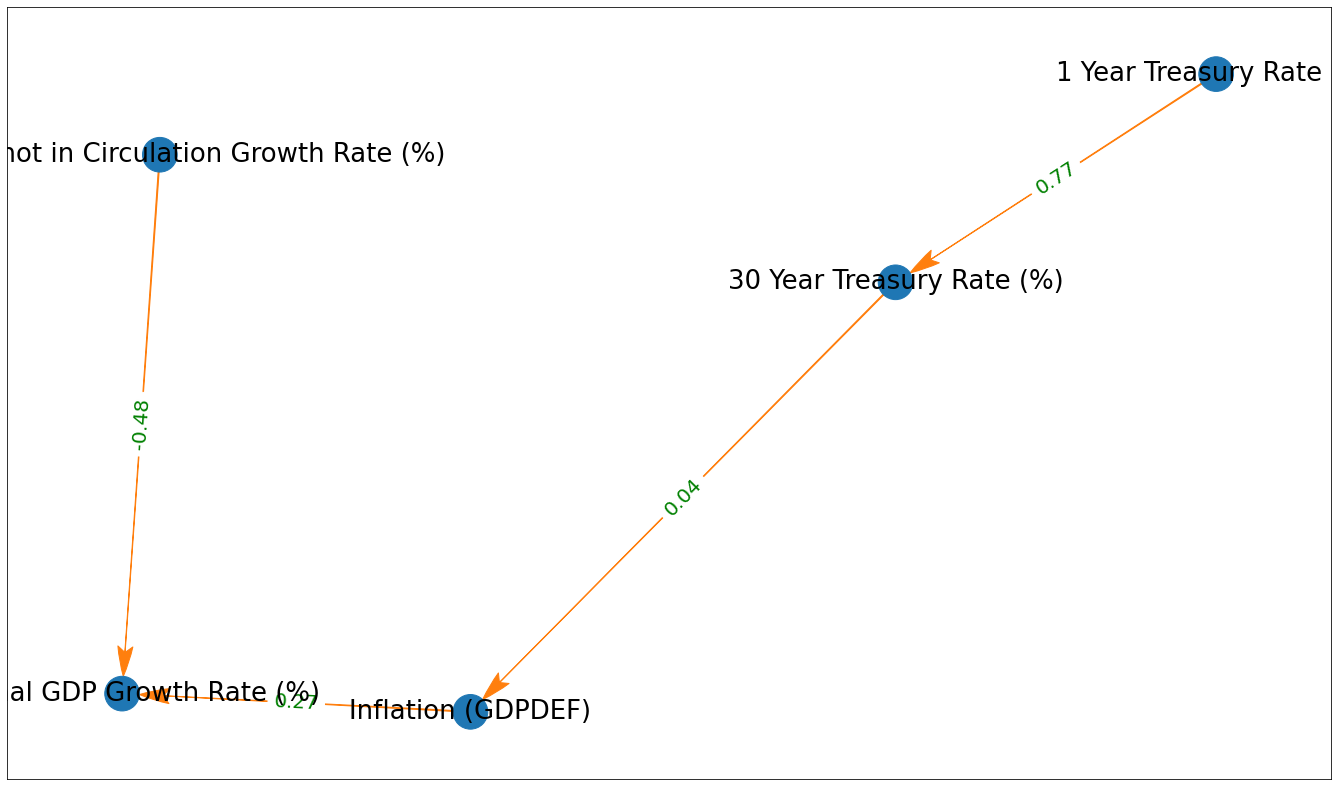

In [6]:
from matplotlib.patches import ArrowStyle
import networkx as nx
def graph_DAG(edges, df, title = ""):
    pcorr = df.pcorr()
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
        
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)

graph_DAG(edges, df[plot_vars])

In [ ]:
def IC_algorithm(df, pcs_dct, sig = .05):
    def gen_pairs(nodes):
        pairs= {key1:[key2 for key2 in nodes if key1 != key2 and pcs_dct[key1][key2]["p-val"] < sig] for key1 in nodes}
        #pairs = {key:[] for key in nodes}
        return pairs
    def check_any_independency(pairs, pcs_dct, 
                               d_graph, sig):
        def check_controls(pairs, pcs_dct,d_graph, x, y, 
                           controls_used, controls_remaining, sig):
            for control in controls_remaining:
                p_val = pcs_dct["p-val"]
                c_p_val = pcs_dct[control]["p-val"]

                
# This is either chain or fork. Sort out which or else arrows will be going in wrong direction...
# use pcs dict and gather list of controls
                if p_val < sig and c_p_val > sig: 
                    if y in pairs[x]:
                        pairs[x].remove(y)
                    if control not in d_graph[x]:
                        if len(controls_used) == 1:
                            pcorrxc = df.partial_corr(x=x,y=control, covar=y,
                                      method="pearson").round(3)
                            if pcorrxc["p-val"].values[0] < sig:
                                d_graph[control].append(x)
                    
                    if x in pairs[y]:
                        pairs[y].remove(x)
                    
                    if control not in d_graph[y]:
                        if len(controls_used) == 1:
                            pcorryc = df.partial_corr(x=control,y=y, covar=x,
                                      method="pearson").round(3)
                            if pcorryc["p-val"].values[0] < sig:
                                d_graph[control].append(y)
                        
                if p_val > sig and c_p_val < sig:
                    if x in pairs[y]:
                        pairs[y].remove(x)
                        pairs[y].append(control)
                        
                    if y in pairs[x]:
                        pairs[x].remove(y)
                        pairs[x].append(control)                    
                    if control not in d_graph[x] and len(controls_used) == 1:
                        d_graph[x].append(control)
                    if control not in d_graph[y] and len(controls_used) == 1:
                        d_graph[y].append(control)

                c_used = copy.copy(controls_used)
                c_remaining = copy.copy(controls_remaining)
                c_used.append(control)
                c_remaining.remove(control)
                check_controls(pairs, pcs_dct[control], d_graph,
                               x, y, c_used, c_remaining, sig)
                
                    
        all_vars = list(pairs.keys())
        for x in all_vars:
            for y in all_vars:
                if x != y:
                    controls = [c for c in all_vars if c != x and c != y]
                    check_controls(pairs, pcs_dct[x][y], d_graph, x, y, [], controls, sig)
                                    
    pairs = gen_pairs(df.keys())
    d_graph = {key:[] for key in pairs}
    check_any_independency(pairs, pcs_dct, d_graph, sig)

    return pairs, d_graph
sig = .05
graph, d_graph = IC_algorithm(df[plot_vars].dropna()[:-1], pcs_dct, sig = sig)
print(d_graph)

In [ ]:
plt.rcParams['axes.ymargin'] = .1
plt.rcParams['axes.xmargin'] = .1
import networkx as nx
from matplotlib.patches import ArrowStyle
def graph_DAG(pairs, title = "Macro Partial Correlations"):

    graph = nx.DiGraph()
    edges = []
    edge_labels = {}
    for x in pairs:
        for y in pairs[x]:
            if (x, y) not in edges:
                edge = (x.replace(" ","\n"), y.replace(" ","\n"))
                edges.append(edge)
                edge_labels[edge] = str(y[1])

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     with_labels=True,  arrows=True,
                     font_size = 26, alpha = .75,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
   
    #nx.draw_networkx_edge_labels(graph,pos,
    #                             edge_labels=edge_labels,
    #                             font_color='green',
    #                             font_size=20)
    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    # tell matplotlib you're done with the plot: https://stackoverflow.com/questions/741877/how-do-i-tell-matplotlib-that-i-am-done-with-a-plot
    plt.show()

graph_DAG(d_graph, "Macro DAG")

In [ ]:
import statsmodels.api as sm
import numpy
residuals = {}
partial_corr = {}
reg_df = df[plot_vars].dropna()[:-1]
for y_var in plot_vars:
    X_vars = [x for x in plot_vars if x != y_var]
    X= reg_df[X_vars]
    X["constant"] = 1
    y = reg_df[y_var]
    model = sm.OLS(y,X)
    results = model.fit()
    print(results.summary())
    predict = results.predict()
    reg_df["predict"] = predict
    residuals[y_var] = results.resid
r2 = {}
for x in plot_vars:
    partial_corr[x] = {}
    r2[x] = {}
    for y in plot_vars:
        if x != y:
            Y = pd.DataFrame(residuals[y])
            X = pd.DataFrame(residuals[x])
            model = sm.OLS(Y,X)
            results = model.fit()
            print(results.rsquared, results.pvalues)
            partial_corr[x][y] = np.corrcoef(residuals[x], residuals[y])[0][1] * -1
            print(partial_corr[x][y])
            print(pcs_dct[x][y])
        
reg_df[plot_vars].pcorr().sort_index(axis=0, ascending=True).sort_index(axis=1, ascending = True)
pd.DataFrame(residuals).corr()


In [ ]:
pd.DataFrame(partial_corr).sort_index(axis=0, ascending=True).sort_index(axis=1, ascending = True)


In [ ]:
corr = reg_df[plot_vars].corr()
pcorr01 = corr[plot_vars[0]][plot_vars[1]]

## Create line plots and scatter plots of variables that you expect to be correlated

In [ ]:
pp = PdfPages("Fed Data" + str(today)[:10] + ".pdf")
plot_vars =["Currency in Circulation Velocity",
            "% Currency in Circulation",
            "1 Year Treasury Rate (%)",
            "Nominal GDP Growth Rate (%)",
           "Private Investment"]
plot_lines(df, plot_vars, linewidth = 3, logy = False, pp = pp)
plot_scatter(df, plot_vars, pp = pp)

plot_vars =["Currency in Circulation Velocity (normalized)",
            "DM4- YoY % Change",
            "DM4- Velocity (normalized)",
            "1 Year Treasury Rate (%)",
            "Nominal GDP Growth Rate (%)"]
plot_lines(df, plot_vars, linewidth = 3, logy = False, pp = pp)
plot_scatter(df, plot_vars, pp = pp)

pp.close()


In [ ]:
#MV=Py
plt.rcParams.update({'font.size': 24})
plot_vars = ["Currency in Circulation Growth Rate (%)",
             #"Log Currency in Circulation Velocity",# (normalized)",
             #"Currency in Circulation % Change Velocity",
             "% Currency not in Circulation",
             "Inflation (GDPDEF)",
             #"Currency not in Circulation Growth Rate (%)",
             #"DM4 YoY % Change", 
             #"DM4 % Change Velocity", 
             "S&P Growth Rate (%)",
             #"S&P Growth Rate Change (%; Year-over-Year)",
             "Nominal GDP Growth Rate (%)",
             #"3 Month Treasury Rate (%)"]
             "1 Year Treasury Rate (%)"]
             #"1 Year Treasury Rate (%; Change Year-over-Year)"]             
             #"30 Year Treasury Rate (%; Change Year-over-Year)"]#,
             #'Effective Federal Funds Rate (%)',
             #"30 Year Minus 3 Month (%)"]#,
             #"30 Year Minus 1 Year (%)"]#,
             #"30 Year Minus Effective Federal Funds Rate"]
pcs_dct, sig_corr = gen_pcorr(df[plot_vars].dropna()[:-1], method = "pearson", sig = .05)
sig_corr

## I expect that velocity will be correlated with the interest rate and that growth of the money stock will be correlated with inflation and nominal interest rates

## So far I have not used the rate of change of velocity, but it will probably be appropriate to check estimates using rates for this variable.

In [ ]:
def graph_pcorr(sig_corr, title = "Macro Partial Correlations"):

    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in sig_corr:
        for key2 in sig_corr[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                edge_labels[edge] = str(key2[1])

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = .8,
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)

graph_pcorr(sig_corr, "Choice Control: Currency in Circulation Growth Rate (%),\nInflation: GDP Deflator")

In [ ]:
#MV=Py

plot_vars = [#"Currency in Circulation Growth Rate (%)",
             #"Log Currency in Circulation Velocity",# (normalized)",
             "Currency in Circulation % Change Velocity",
             #"% Currency not in Circulation",
             "Inflation (CPI)",
             #"Currency not in Circulation Growth Rate (%)",
             #"DM4 YoY % Change", 
             #"DM4 % Change Velocity", 
             #"S&P Growth Rate (%)",
             "Private Investment Growth Rate (%)",
             #"S&P Growth Rate Change (%; Year-over-Year)",
             
             "Nominal GDP Growth Rate (%)",
             #"3 Month Treasury Rate (%)"]
             "1 Year Treasury Rate (%)"]
             #"1 Year Treasury Rate (%; Change Year-over-Year)"]             
             #"30 Year Treasury Rate (%)"]#,
             #'Effective Federal Funds Rate (%)',
             #"30 Year Minus 3 Month (%)"]#,
             #"30 Year Minus 1 Year (%)"]#,
             #"30 Year Minus Effective Federal Funds Rate"]
pcs_dct, sig_corr = gen_pcorr(df[plot_vars].dropna()[:-1], method = "pearson", sig = .05)
graph_pcorr(sig_corr, "Choice Control: Currency in Circulation Growth Rate (%),\nInflation: CPI")

In [ ]:
#MV=Py

plot_vars = [#"Currency in Circulation Growth Rate (%)",
             "Log Currency in Circulation Velocity",# (normalized)",
             #"Currency in Circulation % Change Velocity",
             "% Currency not in Circulation",
             "Inflation (GDPDEF)",
             #"Currency not in Circulation Growth Rate (%)",
             #"DM4 YoY % Change", 
             #"DM4 % Change Velocity", 
             "S&P Growth Rate (%)",
             #"S&P Growth Rate Change (%; Year-over-Year)",
             
             "Nominal GDP Growth Rate (%)",
             #"3 Month Treasury Rate (%)"]
             "1 Year Treasury Rate (%)"]
             #"1 Year Treasury Rate (%; Change Year-over-Year)"]             
             #"30 Year Treasury Rate (%; Change Year-over-Year)"]#,
             #'Effective Federal Funds Rate (%)',
             #"30 Year Minus 3 Month (%)"]#,
             #"30 Year Minus 1 Year (%)"]#,
             #"30 Year Minus Effective Federal Funds Rate"]
pcs_dct, sig_corr = gen_pcorr(df[plot_vars].dropna()[:-1], method = "pearson", sig = .05)
graph_pcorr(sig_corr, "Choice Control: Log Currency in Circulation Velocity,\nInflation: GDP Deflator")

In [ ]:
#MV=Py

plot_vars = [#"Currency in Circulation Growth Rate (%)",
             "Log Currency in Circulation Velocity",# (normalized)",
             #"Currency in Circulation % Change Velocity",
             "% Currency not in Circulation",
             "Inflation (CPI)",
             #"Currency not in Circulation Growth Rate (%)",
             #"DM4 YoY % Change", 
             #"DM4 % Change Velocity", 
             "S&P Growth Rate (%)",
             #"S&P Growth Rate Change (%; Year-over-Year)",
             
             "Nominal GDP Growth Rate (%)",
             #"3 Month Treasury Rate (%)"]
             "1 Year Treasury Rate (%)"]
             #"1 Year Treasury Rate (%; Change Year-over-Year)"]             
             #"30 Year Treasury Rate (%; Change Year-over-Year)"]#,
             #'Effective Federal Funds Rate (%)',
             #"30 Year Minus 3 Month (%)"]#,
             #"30 Year Minus 1 Year (%)"]#,
             #"30 Year Minus Effective Federal Funds Rate"]
pcs_dct, sig_corr = gen_pcorr(df[plot_vars].dropna()[:-1], method = "pearson", sig = .05)
graph_pcorr(sig_corr, "Choice Control: Log Currency in Circulation Velocity,\nInflation: CPI")

In [ ]:
fig, ax = plt.subplots(figsize = (16,10))
df[["Currency in Circulation Velocity", "1 Year Treasury Rate (%)"]].plot(ax = ax, 
    secondary_y = "1 Year Treasury Rate", legend = False)
plt.legend(loc=  "upper right", fontsize = 16)

In [ ]:
plot_vars = [#"Currency in Circulation Growth Rate (%)",
             #"Currency in Circulation % Change Velocity",# (normalized)",
             "Log Currency in Circulation Velocity",
             #"% Currency not in Circulation",
             #"Currency not in Circulation Growth Rate (%)",
             #"DM4 YoY % Change", 
             #"DM4 % Change Velocity", 
             "Real GDP Growth Rate (%)",
             "Inflation (GDP)",
             "Real 1 Year Treasury Rate",
             "10 Year Minus 1 Year (%)"]
pcs_dct, sig_corr = gen_pcorr(df[plot_vars].dropna(), method = "pearson", sig = .01)
graph_pcorr(sig_corr, "Choice Control: Log Currency in Circulation Velocity,\nInflation: CPI")

In [ ]:
# calculate correlation table
df[plot_vars].corr().to_csv("MacroVariableCorr.csv")
df[plot_vars].corr().to_excel("MacroVariableCorr.xlsx")
df[plot_vars].corr()

## No success so far, probably don't understand gomme data...

In [ ]:
gomme_data = pd.read_csv("GommeData.csv", parse_dates = True, 
    index_col = [0]).resample(freq).mean()

for key, val in gomme_data.items():
    df[key] = val.loc["1975":]
    df[key +" (%; Change Year-over-Year)"] = df[key].diff(4)
list(df.keys())

In [ ]:
#MV=Py
plt.rcParams.update({'font.size': 24})
plot_vars = ["Currency in Circulation Growth Rate (%)",
             #"Log Currency in Circulation Velocity",# (normalized)",
             #"Currency in Circulation % Change Velocity",
             "% Currency not in Circulation",
             "Inflation (GDPDEF)",
             #"Currency not in Circulation Growth Rate (%)",
             #"DM4 YoY % Change", 
             #"DM4 % Change Velocity", 
             "S&P Growth Rate (%)",
             #"S&P Growth Rate Change (%; Year-over-Year)",
             "Nominal GDP Growth Rate (%)",
             #"3 Month Treasury Rate (%)"]
             "1 Year Treasury Rate (%)"]
             #"1 Year Treasury Rate (%; Change Year-over-Year)",            
             #"30 Year Treasury Rate (%; Change Year-over-Year)"]#,
             #'Effective Federal Funds Rate (%)',
             #"30 Year Minus 3 Month (%)"]#,
             #"30 Year Minus 1 Year (%)"]#,
             #"30 Year Minus Effective Federal Funds Rate"]
             #'Return to business capital, pre-tax, no capital gain (%; Change Year-over-Year)',
             #'Return to business capital, pre-tax, no capital gain']
             #"Return to all capital, after--tax"]
             #"Solow residual (%; Change Year-over-Year)"]
pcs_dct, sig_corr = gen_pcorr(df[plot_vars].dropna()[:-1], method = "pearson", sig = .05)
graph_pcorr(sig_corr)